# Problem Statement: IMDB Comment Sentiment Classifier

Dataset: For this exercise we will use a dataset hosted at http://ai.stanford.edu/~amaas/data/sentiment/

Problem Statement: This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided.

Launch a spark session, verify the spark session UI

In [10]:
imdb = spark.read.format("json").load("data/imdb-comments.json").repartition(4).cache()

In [11]:
imdb.count()

50000

In [12]:
imdb.printSchema()

root
 |-- content: string (nullable = true)
 |-- label: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [13]:
imdb.show()

+--------------------+-----+------------+---------+
|             content|label|        name|sentiment|
+--------------------+-----+------------+---------+
|I experienced Nig...| test| 10221_8.txt|      pos|
|I'm an action mov...| test|  2038_8.txt|      pos|
|After a decade of...| test| 10738_8.txt|      pos|
|I like "Hack." Th...| test|  423_10.txt|      pos|
|One of the bigges...| test|  2802_8.txt|      pos|
|I just finished a...| test|  1702_7.txt|      pos|
|Most of Chaplin's...| test|  1499_9.txt|      pos|
|This DVD set is t...| test| 12222_7.txt|      pos|
|Hard Justice is a...| test| 2157_10.txt|      pos|
|Dan Finnerty and ...| test|12024_10.txt|      pos|
|OK, well, no one ...| test| 1876_10.txt|      pos|
|The Ali G show wa...| test|  3493_9.txt|      pos|
|In this film, the...| test| 10686_7.txt|      pos|
|I just saw "Eagle...| test| 10929_7.txt|      pos|
|A gang of bandits...| test|  3563_8.txt|      pos|
|There has been a ...| test| 12159_8.txt|      pos|
|This is a c

label - column indicate whethet the data belong to training or test bucket. sentiment - column indicates whether the comment carries positive or negative sentiment. This column has been manually curated.

Find out for each combination of label and sentimnet how many records are there.

In [14]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [15]:

imdb.groupBy("sentiment").pivot("label").count().show()

+---------+-----+-----+
|sentiment| test|train|
+---------+-----+-----+
|      pos|12500|12500|
|      neg|12500|12500|
+---------+-----+-----+



Look at a sample comment value

In [17]:
content = imdb.sample(False, 0.001, 1).first().content
content

"Greta Garbo stars in 'Anna Christie', a very early 1930 MGM 'talkie', the first time 'Garbo Talks'. 'Anna Christie' is a powerful movie but not for everyone. The movie is filmed like a stage play, short on sets and cinematography, long on dialogue and dramatic characterizations. Eugene O'Neil who wrote the play 'Anna Christie' is known for his dark work and Garbo's character Anna Christie is a bleak figure with a tortured past.<br /><br />The sound quality on the DVD was mediocre. Not helping matters is that George F. Marion who plays Anna's estranged dad, Chris Christofferson, is verbally hard to understand. Marion gives a good performance as the old drunken seamen who’s teetering on insanity with his fixation of the evil 'devil sea'. But his dialogue is written with a very heavy Swedish accent, this is true to O'Neils original play. Marie Dressler's dialogue as Marthy Owens is equally hard to understand. Dressler believably portrays a broken down old drunken women, a 'wharf rat'. He

In [18]:
from bs4 import BeautifulSoup
from pyspark.sql.types import * 
import re
def remove_html_tags(text):
    text = BeautifulSoup(text, "html5lib").text.lower() #removed html tags
    text = re.sub("[\W]+", " ", text)
    return text

spark.udf.register("remove_html_tags", remove_html_tags, StringType())

<function __main__.remove_html_tags>

Test the remove_html_tags function

In [20]:
remove_html_tags(content)

'greta garbo stars in anna christie a very early 1930 mgm talkie the first time garbo talks anna christie is a powerful movie but not for everyone the movie is filmed like a stage play short on sets and cinematography long on dialogue and dramatic characterizations eugene o neil who wrote the play anna christie is known for his dark work and garbo s character anna christie is a bleak figure with a tortured past the sound quality on the dvd was mediocre not helping matters is that george f marion who plays anna s estranged dad chris christofferson is verbally hard to understand marion gives a good performance as the old drunken seamen who s teetering on insanity with his fixation of the evil devil sea but his dialogue is written with a very heavy swedish accent this is true to o neils original play marie dressler s dialogue as marthy owens is equally hard to understand dressler believably portrays a broken down old drunken women a wharf rat her dialogue also is true to o neils original 

Apply the the udf on the imdb dataframe.

In [21]:
imdb_clean = imdb.withColumn("content", expr("remove_html_tags(content)")).cache()
imdb_clean.sample(False, 0.001, 1).first().content

'greta garbo stars in anna christie a very early 1930 mgm talkie the first time garbo talks anna christie is a powerful movie but not for everyone the movie is filmed like a stage play short on sets and cinematography long on dialogue and dramatic characterizations eugene o neil who wrote the play anna christie is known for his dark work and garbo s character anna christie is a bleak figure with a tortured past the sound quality on the dvd was mediocre not helping matters is that george f marion who plays anna s estranged dad chris christofferson is verbally hard to understand marion gives a good performance as the old drunken seamen who s teetering on insanity with his fixation of the evil devil sea but his dialogue is written with a very heavy swedish accent this is true to o neils original play marie dressler s dialogue as marthy owens is equally hard to understand dressler believably portrays a broken down old drunken women a wharf rat her dialogue also is true to o neils original 

Use Tokenizer to split the string into terms. Then use StopWordsRemover to remove stop words like prepositions, apply CountVectorizer to find all distinct terms and found of each term per document.

In [22]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover

In [23]:
tokenizer = Tokenizer(inputCol="content", outputCol="terms")
terms_data = tokenizer.transform(imdb_clean)

In [24]:
print(terms_data.sample(False, 0.001, 1).first().terms)

['greta', 'garbo', 'stars', 'in', 'anna', 'christie', 'a', 'very', 'early', '1930', 'mgm', 'talkie', 'the', 'first', 'time', 'garbo', 'talks', 'anna', 'christie', 'is', 'a', 'powerful', 'movie', 'but', 'not', 'for', 'everyone', 'the', 'movie', 'is', 'filmed', 'like', 'a', 'stage', 'play', 'short', 'on', 'sets', 'and', 'cinematography', 'long', 'on', 'dialogue', 'and', 'dramatic', 'characterizations', 'eugene', 'o', 'neil', 'who', 'wrote', 'the', 'play', 'anna', 'christie', 'is', 'known', 'for', 'his', 'dark', 'work', 'and', 'garbo', 's', 'character', 'anna', 'christie', 'is', 'a', 'bleak', 'figure', 'with', 'a', 'tortured', 'past', 'the', 'sound', 'quality', 'on', 'the', 'dvd', 'was', 'mediocre', 'not', 'helping', 'matters', 'is', 'that', 'george', 'f', 'marion', 'who', 'plays', 'anna', 's', 'estranged', 'dad', 'chris', 'christofferson', 'is', 'verbally', 'hard', 'to', 'understand', 'marion', 'gives', 'a', 'good', 'performance', 'as', 'the', 'old', 'drunken', 'seamen', 'who', 's', 'tee

In [25]:
remover = StopWordsRemover(inputCol="terms", outputCol="filtered")
terms_stop_removed = remover.transform(terms_data)

In [26]:
print(terms_stop_removed.sample(False, 0.001, 1).first().filtered)

['greta', 'garbo', 'stars', 'anna', 'christie', 'early', '1930', 'mgm', 'talkie', 'first', 'time', 'garbo', 'talks', 'anna', 'christie', 'powerful', 'movie', 'everyone', 'movie', 'filmed', 'like', 'stage', 'play', 'short', 'sets', 'cinematography', 'long', 'dialogue', 'dramatic', 'characterizations', 'eugene', 'o', 'neil', 'wrote', 'play', 'anna', 'christie', 'known', 'dark', 'work', 'garbo', 'character', 'anna', 'christie', 'bleak', 'figure', 'tortured', 'past', 'sound', 'quality', 'dvd', 'mediocre', 'helping', 'matters', 'george', 'f', 'marion', 'plays', 'anna', 'estranged', 'dad', 'chris', 'christofferson', 'verbally', 'hard', 'understand', 'marion', 'gives', 'good', 'performance', 'old', 'drunken', 'seamen', 'teetering', 'insanity', 'fixation', 'evil', 'devil', 'sea', 'dialogue', 'written', 'heavy', 'swedish', 'accent', 'true', 'o', 'neils', 'original', 'play', 'marie', 'dressler', 'dialogue', 'marthy', 'owens', 'equally', 'hard', 'understand', 'dressler', 'believably', 'portrays',

In [27]:
count_vectorizer = CountVectorizer(inputCol="filtered", outputCol="count_vectors")
count_vectorizer_model = count_vectorizer.fit(terms_stop_removed)
count_vectorized = count_vectorizer_model.transform(terms_stop_removed)
count_vectorized.sample(False, 0.001, 1).first().count_vectors

SparseVector(103999, {0: 2.0, 2: 2.0, 3: 1.0, 4: 1.0, 5: 2.0, 16: 1.0, 17: 1.0, 25: 1.0, 26: 1.0, 33: 2.0, 63: 2.0, 65: 1.0, 67: 1.0, 70: 1.0, 79: 1.0, 95: 1.0, 108: 2.0, 110: 1.0, 116: 1.0, 136: 2.0, 141: 1.0, 147: 2.0, 152: 1.0, 156: 1.0, 179: 4.0, 182: 2.0, 186: 2.0, 192: 1.0, 204: 1.0, 214: 1.0, 225: 1.0, 237: 1.0, 252: 2.0, 274: 3.0, 278: 1.0, 291: 1.0, 292: 1.0, 295: 1.0, 299: 4.0, 300: 1.0, 316: 1.0, 334: 1.0, 341: 2.0, 350: 1.0, 365: 1.0, 388: 1.0, 390: 1.0, 392: 1.0, 431: 1.0, 452: 2.0, 509: 1.0, 512: 1.0, 517: 1.0, 520: 1.0, 521: 1.0, 579: 3.0, 603: 1.0, 606: 1.0, 626: 1.0, 668: 1.0, 677: 1.0, 714: 1.0, 791: 1.0, 834: 1.0, 835: 1.0, 851: 1.0, 858: 1.0, 927: 1.0, 1022: 1.0, 1067: 1.0, 1071: 1.0, 1081: 1.0, 1107: 1.0, 1129: 1.0, 1134: 1.0, 1172: 1.0, 1191: 1.0, 1194: 1.0, 1212: 1.0, 1264: 1.0, 1266: 1.0, 1409: 1.0, 1415: 1.0, 1441: 1.0, 1497: 1.0, 1693: 1.0, 1773: 1.0, 2057: 1.0, 2071: 7.0, 2079: 1.0, 2135: 1.0, 2155: 1.0, 2310: 1.0, 2327: 1.0, 2341: 1.0, 2486: 1.0, 2663: 1.0, 

count_vectorized Dataframe contains a column count_vectors that is a SparseVector representing which term appears and how many times. The key is the index of all unique terms. You can find list of terms count_vectorizer_model.vocabulary. See below.

In [28]:
print(count_vectorizer_model.vocabulary[:100], "\n\nTotal no of terms", len(count_vectorizer_model.vocabulary))

['movie', 'film', 'one', 'like', 'good', 'time', 'even', 'story', 'really', 'see', 'well', 'much', 'bad', 'get', 'people', 'great', 'also', 'first', 'made', 'make', 'way', 'movies', 'characters', 'think', 'watch', 'character', 'films', 'two', 'many', 'seen', 'love', 'never', 'plot', 'life', 'acting', 'show', 'best', 'know', 'little', 'ever', 'man', 'better', 'end', 'scene', 'still', 'say', 'scenes', 've', 'something', 'm', 'go', 'back', 'real', 'thing', 'watching', 'actors', 're', 'doesn', 'director', 'didn', 'years', 'funny', 'though', 'old', 'another', 'work', '10', 'actually', 'nothing', 'makes', 'look', 'find', 'going', 'new', 'lot', 'every', 'part', 'world', 'cast', 'us', 'things', 'want', 'quite', 'pretty', 'horror', 'around', 'seems', 'young', 'take', 'however', 'big', 'got', 'thought', 'fact', 'enough', 'long', 'give', 'may', 'comedy', 'series'] 

Total no of terms 103999


In [29]:
count_vectorized.show()

+--------------------+-----+------------+---------+--------------------+--------------------+--------------------+
|             content|label|        name|sentiment|               terms|            filtered|       count_vectors|
+--------------------+-----+------------+---------+--------------------+--------------------+--------------------+
|i experienced nig...| test| 10221_8.txt|      pos|[i, experienced, ...|[experienced, nig...|(103999,[1,3,5,7,...|
|i m an action mov...| test|  2038_8.txt|      pos|[i, m, an, action...|[m, action, movie...|(103999,[0,4,5,9,...|
|after a decade of...| test| 10738_8.txt|      pos|[after, a, decade...|[decade, turbulen...|(103999,[0,1,2,3,...|
|i like hack think...| test|  423_10.txt|      pos|[i, like, hack, t...|[like, hack, thin...|(103999,[3,5,10,1...|
|one of the bigges...| test|  2802_8.txt|      pos|[one, of, the, bi...|[one, biggest, fr...|(103999,[0,1,2,3,...|
|i just finished a...| test|  1702_7.txt|      pos|[i, just, finishe...|[finishe

SparkVector represents a vector of 103999, that means in the dataset (corpus) there are 103999 unique terms. Per document, only a few will be present. Find density of each count_vectors.

In [30]:
vocab_len = len(count_vectorizer_model.vocabulary)
spark.udf.register("density", lambda r: r.numNonzeros() / vocab_len, DoubleType())
count_vectorized.select(expr("density(count_vectors) density")).show()

+--------------------+
|             density|
+--------------------+
|9.134703218300176E-4|
|8.077000740391734E-4|
|0.001192319156914...|
|6.634679179607497E-4|
|0.002269252588967...|
|0.001115395340339811|
| 8.75008413542438E-4|
|0.003375032452235...|
|0.001173088202771...|
|5.961595784574851E-4|
|5.576976701699055E-4|
|7.211607803921192E-4|
|9.038548447581227E-4|
|2.115404955816883E-4|
|0.001500014423215...|
|0.001961557322666564|
|8.461619823267531E-4|
|5.192357618823258E-4|
|0.001451937037856...|
| 2.50002403869268E-4|
+--------------------+
only showing top 20 rows



Density report shows, the count_vectors has very low density which illustrate the benefit of the choice of DenseVector for this column.

Now, calculate tfidf for the document

In [31]:
idf = IDF(inputCol="count_vectors", outputCol="features")
idf_model = idf.fit(count_vectorized)
idf_data = idf_model.transform(count_vectorized)

In [32]:
idf_data.sample(False, 0.001, 1).first().features

SparseVector(103999, {0: 0.9845, 2: 1.1288, 3: 0.7696, 4: 0.9676, 5: 2.119, 16: 1.3666, 17: 1.3774, 25: 1.6553, 26: 1.698, 33: 3.4157, 63: 4.0136, 65: 1.9844, 67: 1.986, 70: 1.9881, 79: 2.2231, 95: 2.1487, 108: 4.8333, 110: 2.268, 116: 2.2797, 136: 4.8495, 141: 2.4541, 147: 4.7409, 152: 2.4588, 156: 2.548, 179: 10.5905, 182: 5.1155, 186: 5.1016, 192: 2.6086, 204: 2.6527, 214: 2.7536, 225: 2.7561, 237: 2.8205, 252: 5.9661, 274: 8.5544, 278: 2.886, 291: 2.9114, 292: 2.8914, 295: 2.8661, 299: 11.7681, 300: 2.9019, 316: 2.9565, 334: 3.087, 341: 6.1898, 350: 3.1981, 365: 3.0692, 388: 3.1181, 390: 3.163, 392: 3.1531, 431: 3.2075, 452: 6.584, 509: 3.2985, 512: 3.4489, 517: 3.345, 520: 3.4427, 521: 3.3726, 579: 10.8919, 603: 3.6707, 606: 3.4848, 626: 3.5173, 668: 3.6321, 677: 3.5699, 714: 3.6489, 791: 3.8633, 834: 3.8222, 835: 3.8059, 851: 3.7775, 858: 3.8122, 927: 3.8874, 1022: 3.9987, 1067: 4.096, 1071: 4.1839, 1081: 4.2773, 1107: 4.0479, 1129: 4.2904, 1134: 4.1154, 1172: 4.1997, 1191: 4.222

In [33]:
idf_data.printSchema()

root
 |-- content: string (nullable = true)
 |-- label: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- terms: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- count_vectors: vector (nullable = true)
 |-- features: vector (nullable = true)




Apply StringIndexer to conver the sentiment column from String type to number type - this is prerequisit to apply the LogisticRegression algorithm.

In [35]:
from pyspark.ml.feature import StringIndexer

In [36]:
string_indexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_idx")
string_indexer_model = string_indexer.fit(idf_data)
label_encoded = string_indexer_model.transform(idf_data)

In [37]:
label_encoded.select("sentiment", "sentiment_idx").show()

+---------+-------------+
|sentiment|sentiment_idx|
+---------+-------------+
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
+---------+-------------+
only showing top 20 rows



Split the data into traininf and testing groups with 70/30 ratio. Cache the dataframe so that training runs faster.

In [39]:
training, testing = label_encoded.randomSplit(weights=[0.7, 0.3], seed=1)
training.cache()
testing.cache()

DataFrame[content: string, label: string, name: string, sentiment: string, terms: array<string>, filtered: array<string>, count_vectors: vector, features: vector, sentiment_idx: double]

Verify that the StringIndex has done the expected job and training and testing data maintain the ratio of positive and negative records as in the whole dataset.

In [40]:
training.groupBy("sentiment_idx", "sentiment").count().show()

+-------------+---------+-----+
|sentiment_idx|sentiment|count|
+-------------+---------+-----+
|          1.0|      pos|17539|
|          0.0|      neg|17517|
+-------------+---------+-----+



In [41]:
testing.groupBy("sentiment_idx", "sentiment").count().show()

+-------------+---------+-----+
|sentiment_idx|sentiment|count|
+-------------+---------+-----+
|          1.0|      pos| 7461|
|          0.0|      neg| 7483|
+-------------+---------+-----+



Apply LogisticRegression classifier

In [42]:
from pyspark.ml.classification import LogisticRegression

In [43]:

lr = LogisticRegression(maxIter=10000, regParam=0.1, elasticNetParam=0.0, 
                        featuresCol="features", labelCol="sentiment_idx")

Show the parameters that the LogisticRegression classifier takes.

In [44]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: sentiment_idx)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constra

In [45]:
lr_model = lr.fit(training)

In [46]:
lr_model.coefficients[:100]

array([-2.12408368e-02,  4.24331169e-03,  9.04075972e-03, -1.10549950e-02,
        3.15572008e-02,  5.97383812e-03, -5.41811859e-02,  9.48704943e-03,
       -8.29936120e-04,  4.45092710e-02,  6.09165123e-02, -2.07895557e-02,
       -1.01105448e-01, -1.38854245e-03,  8.75944124e-03,  1.12307270e-01,
        3.66491186e-02,  1.59161945e-02, -1.51438903e-02, -3.44387586e-02,
        4.85284636e-03, -4.95223684e-03, -6.67006765e-03,  2.56530952e-02,
        9.38905604e-03, -4.85430486e-03,  9.52027628e-03,  7.46014994e-07,
        1.35883512e-02,  1.98328265e-02,  4.80577752e-02, -1.62597192e-03,
       -5.23760256e-02,  2.47350347e-02, -5.35497047e-02,  5.22112043e-03,
        8.12680871e-02,  2.50557977e-03,  1.34682961e-02, -1.30119447e-02,
        1.04567333e-02, -3.92096685e-02, -3.17837356e-04, -6.04435608e-03,
        4.97924274e-02, -3.43252126e-03, -1.18994543e-02, -3.15143995e-03,
       -1.41177029e-02, -1.95237924e-02,  2.75885259e-03,  9.52265266e-03,
        1.76776029e-02, -

In [48]:
training_summary = lr_model.summary

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Text(0,0.5,'Cost')

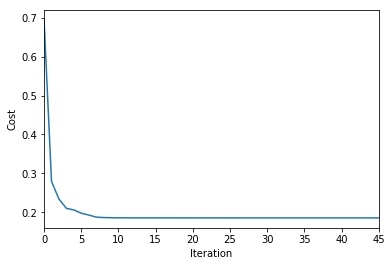

In [51]:
pd.Series(training_summary.objectiveHistory).plot()
plt.xlabel("Iteration")
plt.ylabel("Cost")

In [53]:
training_summary.areaUnderROC

0.9998517937644785

In [ ]:

predictions = lr_model.transform(testing).withColumn("match", expr("prediction == sentiment_idx"))